In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


## Utilities

In [2]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "red")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Exploring the dataset

In [3]:
training_labels = pd.read_csv("../datasets/scene classification/train_labels.csv")   
training_labels["label"] = training_labels["label"].astype(str)
training_labels.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


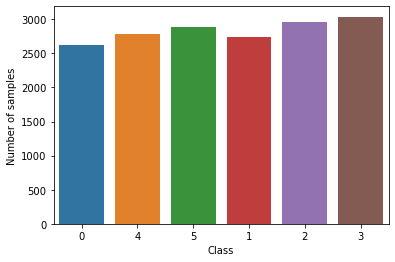

In [4]:
sns.countplot(x ='label', data=training_labels)                       
plt.xlabel("Class")                                               
plt.ylabel("Number of samples")
plt.show() 

note the calsses almost balanced! no need to rebalance the data 

In [5]:
#splitting the dataset into trian, validate and test
data_train_labels, data_test_labels = train_test_split(training_labels, test_size=0.2)   
data_train_labels, data_validate_labels = train_test_split(training_labels, test_size=0.25)   

In [6]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications import ResNet152V2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

## Preprocessing using keras generators(training, validation & testing)

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=False,
    vertical_flip=False)                           
dir_path= "../datasets/scene classification/images"

In [8]:
train_gen=datagen.flow_from_dataframe(dataframe = data_train_labels,           
                                      directory=dir_path,                   
                                      batch_size=32,                   
                                      class_mode="categorical",         
                                      x_col="image_name",
                                      y_col="label",
                                      color_mode="rgb",   
                                      target_size=(224,224))      

Found 12775 validated image filenames belonging to 6 classes.


In [9]:
valid_gen=datagen.flow_from_dataframe(dataframe = data_validate_labels,           
                                      directory=dir_path, 
                                      batch_size=32,                   
                                      class_mode="categorical",         
                                      x_col="image_name",
                                      y_col="label",
                                      color_mode="rgb",   
                                      target_size=(224,224))  

Found 4259 validated image filenames belonging to 6 classes.


## Model architecutre

In [11]:
def ResNet_model (input_shape):
    base_model=ResNet152V2(weights='imagenet',include_top=False,input_shape=input_shape)
    for layer in base_model.layers[:-15]:  
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output= Dense(units=6, activation='softmax')(x)
    model = Model(base_model.input, output)
    return model


In [12]:
Model= ResNet_model(input_shape =(224, 224, 3))
print(Model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

## Model training 

In [13]:
def compile_and_train(model, num_epochs):
    STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
    STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
    adam =  Adam(lr=0.001) 
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['acc'])
    Model_history= model.fit_generator(generator=train_gen,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,validation_steps=STEP_SIZE_VALID,epochs=num_epochs)
    return  Model_history

In [14]:
model_his= compile_and_train(Model, num_epochs=2) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
399/399 [==============================] - 6829s 17s/step - loss: 0.3667 - acc: 0.8823 - val_loss: 0.3376 - val_acc: 0.8820
Epoch 2/2
399/399 [==============================] - 6936s 17s/step - loss: 0.2259 - acc: 0.9232 - val_loss: 0.3716 - val_acc: 0.8750


In [15]:
Model.save(Model.name + '.hdf5')
Model.save_weights("ModelWeights.hdfs")